Pas de discritization dx=dy= 0.2 m
Pas de discritization dx=dy= 0.1 m
Pas de discritization dx=dy= 0.05 m
Pas de discritization dx=dy= 0.025 m
[55.63382396 39.68841765 32.3737147  28.3333092 ]


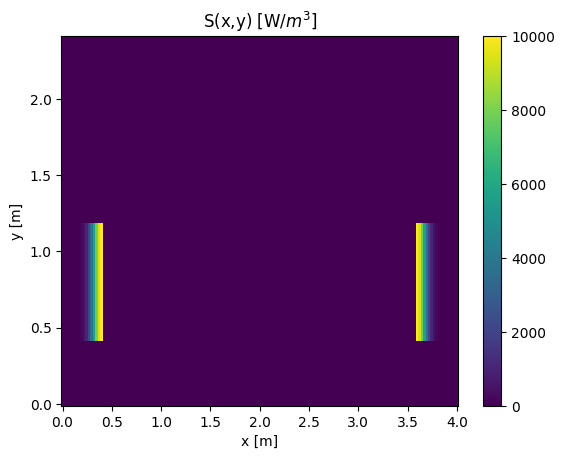

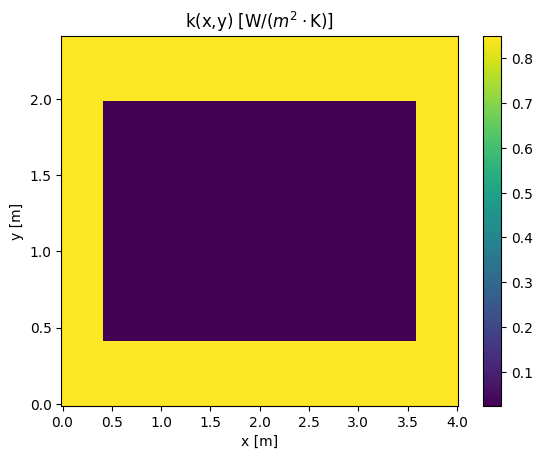

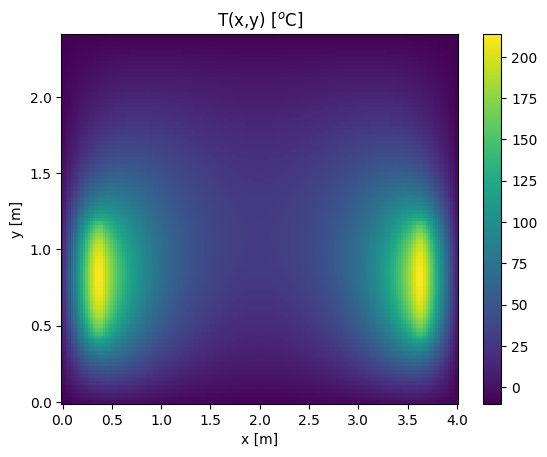

[0.1   0.05  0.025] [15.94540631  7.31470295  4.0404055 ]


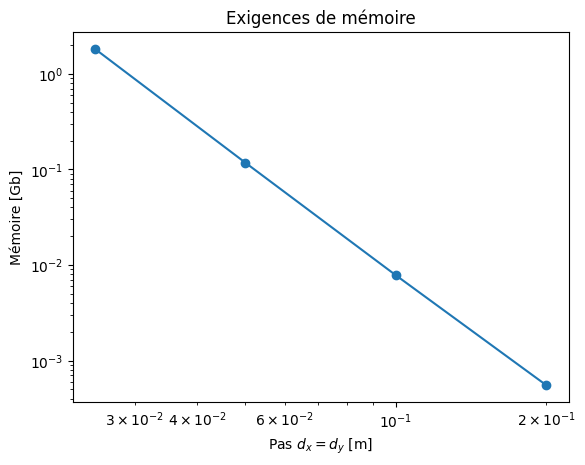

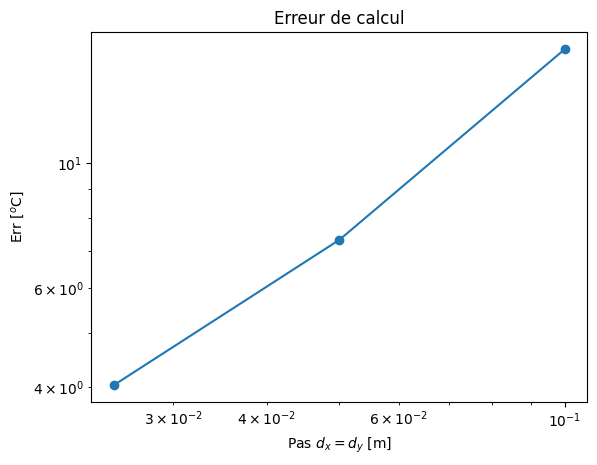

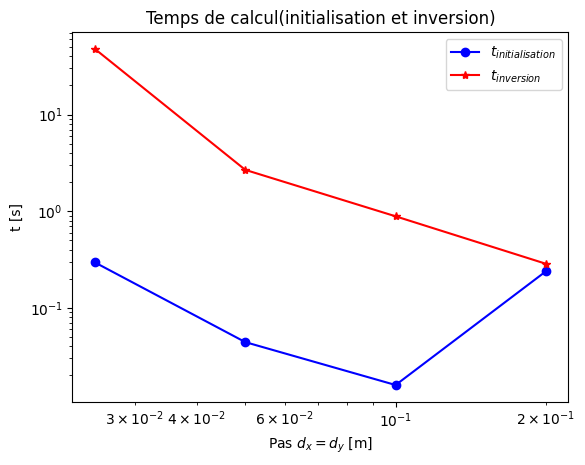

In [41]:
import time
import numpy as np
import matplotlib.pyplot as plt

# Distribution de la température dans un appartement d'un immeuble aux plusieurs étages


# Équation de transfert de chaleur:
# k*(d^2 T(x,y)/dx^2 + d^2 T(x,y)/dy^2)+S=0


# Conditions aux limites:

# (1) Condition convective (de Robin) à x=0 et à x=Lx (faces externes du mur):
# -k*dT(x=0,y)/dx=-h*(T-Ta)
# -k*dT(x=L,y)/dx=h*(T-Ta)
Ta=-10 #oC

# (2) Condition de Dirichlet sur le plafond et sur le plancher
# T(x, y=0 ou y=Ly)=Tp
Tp=20; #oC

# Dimensions d'appartement
Lx=4; #[m]
Ly=2.4;  #[m]

# Parametres d'un mur d'isolation thermique
Lm=0.4; #m ; Épaisseur du mur en brique
km=0.85;#W/(m*K); La conductivité thermique de la brique
h=20 #W/(m^2*K); Coefficient de transfert thermique sur les surfaces extérieures du mur

# Paramètres de l'air qui remplit l'appartement
ka=0.024

fact_ar = np.array([2, 1, 0.5, 0.25], dtype=np.double); # Matrice pleine
d_ar=np.zeros(fact_ar.size,dtype=np.double)
tini_ar=np.zeros(fact_ar.size,dtype=np.double)
tinv_ar=np.zeros(fact_ar.size,dtype=np.double)
mem_ar=np.zeros(fact_ar.size,dtype=np.double)
Tm_ar=np.zeros(fact_ar.size,dtype=np.double)
Err_ar=np.zeros(fact_ar.size-1,dtype=np.double)
d_Err_ar=np.zeros(fact_ar.size-1,dtype=np.double)

ci=-1
for fact in fact_ar:
    ci=ci+1
    d=0.1*fact   #Pas de discrétisation en [m]
    print('Pas de discritization dx=dy=',d,'m')
    d_ar[ci]=d
    Nx=int(np.rint(Lx/d+1)) # Nombre de nœuds le long de X
    Ny=int(np.rint(Ly/d+1)) # Nombre de nœuds le long de Y
    
    
    tic=time.time_ns()
    
    # Initialisation de la source de chaleur, de la conductivité thermique et de la matrice
    S=np.zeros((Ny,Nx),dtype=np.double)
    k=np.zeros((Ny,Nx),dtype=np.double)
    
    for i in np.arange(1,Ny+1,1): #i=1,..,Ny - numérotation des nœuds sur un maillage physique
        y=(i-1)*d
        for j in np.arange(1,Nx+1,1): #j=1,..,Nx - numérotation des nœuds sur un maillage physique
            x=(j-1)*d
            
            # Sourse volumique de chaleur q[W/m^3] d'épaisseur dL.
            # La source est intégrée dans les parties intérieures du mur à x=Lm et à x=Lx-Lm et
            # il occupe les tiers du mur dans la direction verticale
            dL=0.1
            q=1.0e4;# W/m^3;
            if ((x<=Lm) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((x-Lm)/dL)**2)
            elif ((x>=(Lx-Lm)) and (y<=Ly/3+Lm) and (y>Lm)):
                # À l'intérieur de l'élément chauffant
                S[i-1,j-1]=q*np.exp(-((Lx-Lm-x)/dL)**2)
            else:
                # À l'extérieur de l'élément chauffant
                S[i-1,j-1]=0.0
            
            # L'espace de vie de l'appartement est délimité par
            # les parois d'épaisseur Lm à tous les quatre côtés
            if ((x<=Lm) or (x>=(Lx-Lm)) or (y<=Lm) or (y>=(Ly-Lm))):
                # À l'intérieur du mur
                k[i-1,j-1]=km
            else:
                # À l'intérieur de de l'appartement
                k[i-1,j-1]=ka
               
    M=np.zeros((Nx*Ny,Nx*Ny),dtype=np.double)
    b=np.zeros((Nx*Ny,1),dtype=np.double)
    T=np.zeros((Nx*Ny,1),dtype=np.double)
    Tr=np.zeros((Ny,Nx),dtype=np.double)
    
    for i in np.arange(1,Ny+1,1):
        for j in np.arange(1,Nx+1,1):
            # remplir la ligne pl de la matrice M
            pl=(i-1)*Nx+j
          
            if (((i>1) and (i<Ny)) and ((j>1) and (j<Nx))):
                # noeud qui est strictement à l'intérieur de la cellule de simulation
                pc=pl
                M[pl-1,pc-1]=-4 # contribution de noeud (i,j)
                pc=(i-1)*Nx+j-1
                M[pl-1,pc-1]=1 # contribution de noeud (i,j-1)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]=1 # contribution de noeud (i,j+1)
                pc=(i-2)*Nx+j
                M[pl-1,pc-1]=1 # contribution de noeud (i-1,j)
                pc=(i)*Nx+j
                M[pl-1,pc-1]=1 # contribution de noeud (i+1,j)
                b[pl-1]=-d**2*S[i-1,j-1]/k[i-1,j-1]
                
            elif (i==1) and (j!=1):
                # noeud sur le plafond y=0
                pc=pl
                M[pl-1,pc-1]= 3+2*d*h/k[i-1,j-1]# contribution de noeud (1,j)
                pc=(j-1)+Nx
                M[pl-1,pc-1]=-4 # contribution de noeud (Nx,j)
                pc=(j-2)+2*Nx
                M[pl-1,pc-1]=1 # contribution de noeud (2Nx,j)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]

            elif (i==Ny) and (j!=Nx):
                # noeud sur le plancher y=Ly
                pc=pl
                M[pl-1,pc-1]= 3+2*d*h/k[i-1,j-1]# contribution de noeud (Nx,j)
                pc=(j+1-Nx)-Nx
                M[pl-1,pc-1]=-4 # contribution de noeud (Nx,j)
                pc=(j+2-Nx)-Nx-Nx
                M[pl-1,pc-1]=1 # contribution de noeud (2Nx,j)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]

            elif (j==1):
                # noeud à la surface externe du mur x=0
                pc=pl
                M[pl-1,pc-1]=3+2*d*h/k[i-1,j-1] # contribution de noeud (i,1)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]=-4 # contribution de noeud (i,2)
                pc=(i-1)*Nx+j+2
                M[pl-1,pc-1]=1 # contribution de noeud (i,3)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]
            elif (j==Nx):
                # noeud à la surface externe du mur x=Nx
                pc=pl
                M[pl-1,pc-1]=3+2*d*h/k[i-1,j-1] # contribution de noeud (i,Nx)
                pc=(i-1)*Nx+j-1
                M[pl-1,pc-1]=-4 # contribution de noeud (i,Nx-1)
                pc=(i-1)*Nx+j-2
                M[pl-1,pc-1]=1 # contribution de noeud (i,Nx-2)
                b[pl-1]=2*d*h*Ta/k[i-1,j-1]
                
                
                
                
            elif ((i-1)*d == Lm) or Lm-d <(i-1)*d < Lm+d:
                pc=pl
                M[pl-1,pc-1]= 3*(km+ka) # contribution de noeud (i,j)
                pc=(i-2)*Nx+j
                M[pl-1,pc-1]=-4*km # contribution de noeud (i-1,j)
                pc=(i-3)*Nx+j
                M[pl-1,pc-1]=km # contribution de noeud (i-2,j)
                pc=(i)*Nx+j
                M[pl-1,pc-1]= -4*ka # contribution de noeud (i+1,j)
                pc=(i+1)*Nx+j
                M[pl-1,pc-1]=ka # contribution de noeud (i-1,j)
                b[pl-1]= 0
            elif ((j-1)*d == Lm) or  Lm-d <(j-1)*d < Lm+d:
                pc=pl
                M[pl-1,pc-1]= 3*(km+ka) # contribution de noeud (i,j)
                pc=(i-1)*Nx+j-1
                M[pl-1,pc-1]=-4*km # contribution de noeud (i,j-1)
                pc=(i-1)*Nx+j-2
                M[pl-1,pc-1]=km # contribution de noeud (i,j-2)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]= -4*ka # contribution de noeud (i,j+1)
                pc=(i-1)*Nx+j+2
                M[pl-1,pc-1]=ka # contribution de noeud (i,j+2)
                b[pl-1]= 0
            elif ((j-1)*d == Ly-Lm) or  Lm-d <(j-1)*d < Lm+d:
                pc=pl
                M[pl-1,pc-1]= 3*(km+ka) # contribution de noeud (i,j)
                pc=(i-1)*Nx+j-1
                M[pl-1,pc-1]=-4*ka # contribution de noeud (i,j-1)
                pc=(i-1)*Nx+j-2
                M[pl-1,pc-1]=ka # contribution de noeud (i,j-2)
                pc=(i-1)*Nx+j+1
                M[pl-1,pc-1]= -4*km # contribution de noeud (i,j+1)
                pc=(i-1)*Nx+j+2
                M[pl-1,pc-1]=km # contribution de noeud (i,j+2)
                b[pl-1]= 0
            elif ((i-1)*d == Ly-Lm) or  Lm-d <(i-1)*d < Lm+d:
                pc=pl
                M[pl-1,pc-1]= 3*(km+ka) # contribution de noeud (i,j)
                pc=(i-2)*Nx+j
                M[pl-1,pc-1]=-4*ka # contribution de noeud (i-1,j)
                pc=(i-3)*Nx+j
                M[pl-1,pc-1]=ka # contribution de noeud (i-2,j)
                pc=(i)*Nx+j
                M[pl-1,pc-1]= -4*km # contribution de noeud (i+1,j)
                pc=(i+1)*Nx+j
                M[pl-1,pc-1]=km # contribution de noeud (i-1,j)
                b[pl-1]= 0
        
            
            else:
                print('Erreur dans la définition de la matrice de coefficients')
                
    toc=time.time_ns()
    tini_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    tic=time.time_ns()
    T=np.linalg.solve(M,b)
    toc=time.time_ns()
    tinv_ar[ci]=(toc-tic)/1.0e9; #temps en [s]  
    
    mem_ar[ci]=8*(Nx*Ny)**2
    
    Tr=np.reshape(T,(Ny,Nx),order='C')
    
    Tm_ar[ci]=Tr[int(np.rint(Ly/(2*d)+1)),int(np.rint(Lx/(2*d)+1))] # température au milieu du domaine de calcul
print(Tm_ar)

plt.figure(1)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,S)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('S(x,y) [W/$m^3$]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(2)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,k)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('k(x,y) [W/($m^2\cdot$K)]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(3)
plt.pcolor(np.arange(0,Nx,1)*d,np.arange(0,Ny,1)*d,Tr)
plt.colorbar(mappable=None, cax=None, ax=None)
plt.title('T(x,y) [$^o$C]')
plt.xlabel('x [m]')    
plt.ylabel('y [m]')
plt.show()

plt.figure(4)
plt.loglog(d_ar[::-1],mem_ar[::-1]/1024.0**3,'-o')
plt.title('Exigences de mémoire')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Mémoire [Gb]')


plt.figure(5)
Err_ar=abs(Tm_ar[:-1:]-Tm_ar[1::])
d_Err_ar=d_ar[1::]; # Definiton d'erreur Err(delta)=|Tm(2*delta)-Tm(delta)|
plt.loglog(d_Err_ar[::-1],Err_ar[::-1],'-o')
plt.title('Erreur de calcul')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Err [$^o$C]')
print(d_Err_ar, Err_ar)


plt.figure(6)
plt.loglog(d_ar[::-1],tini_ar[::-1],'-bo',d_ar[::-1],tinv_ar[::-1],'-r*')
plt.title('Temps de calcul(initialisation et inversion)')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend(['$t_{initialisation}$','$t_{inversion}$'])


The value of x at 250GB is approximately: 0.007018185258760681 meters


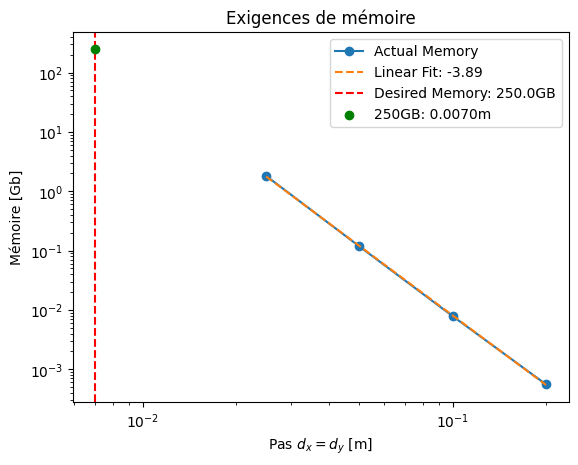

In [42]:
# Store the data in arrays
x_values = d_ar[::-1]
y_values = mem_ar[::-1] / 1024.0**3  # Memory in GB

# Perform linear fit
coefficients = np.polyfit(np.log(x_values), np.log(y_values), 1)

# Calculate the x_values for the desired memory (250GB)
desired_memory = 250.0
desired_x_value = np.exp((np.log(desired_memory) - coefficients[1]) / coefficients[0])

# Generate fitted values
fit_values = np.exp(np.polyval(coefficients, np.log(x_values)))

# Find the index where the fitted memory reaches 250GB
index_250GB = np.argmax(fit_values == desired_memory)

# Get the corresponding x value at that index
x_value_at_250GB = x_values[index_250GB]

# Print the result
print(f"The value of x at 250GB is approximately: {desired_x_value} meters")

# Plot the results
plt.figure(4)
plt.loglog(x_values, y_values, '-o', label='Actual Memory')
plt.loglog(x_values, fit_values, '--', label=f'Linear Fit: {coefficients[0]:.2f}')
plt.axvline(x=desired_x_value, color='red', linestyle='--', label=f'Desired Memory: {desired_memory}GB')
plt.scatter(desired_x_value, desired_memory, color='green', label=f'250GB: {desired_x_value:.4f}m', zorder=5)
plt.title('Exigences de mémoire')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Mémoire [Gb]')
plt.legend()
plt.show()

The value of x at 10.0s for initialization is approximately: 0.025 meters
The value of x at 10.0s for inversion is approximately: 0.025 meters


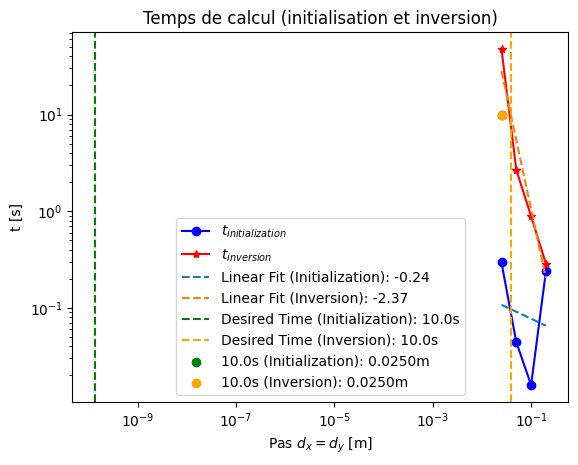

Estimated initialization time for dx = 0.007: 0.1456 seconds
Estimated inversion time for dx = 0.007: 576.8053 seconds


In [43]:

# Store the data in arrays
x_values = d_ar[::-1]
y_values_initialization = tini_ar[::-1]
y_values_inversion = tinv_ar[::-1]

# Perform linear fits for initialization and inversion times
coefficients_initialization = np.polyfit(np.log(x_values), np.log(y_values_initialization), 1)
coefficients_inversion = np.polyfit(np.log(x_values), np.log(y_values_inversion), 1)

# Calculate the x_values for the desired time (e.g., 10 seconds for initialization)
desired_time_initialization = 10.0
desired_x_value_initialization = np.exp((np.log(desired_time_initialization) - coefficients_initialization[1]) / coefficients_initialization[0])

# Calculate the x_values for the desired time (e.g., 10 seconds for inversion)
desired_time_inversion = 10.0
desired_x_value_inversion = np.exp((np.log(desired_time_inversion) - coefficients_inversion[1]) / coefficients_inversion[0])

# Generate fitted values
fit_values_initialization = np.exp(np.polyval(coefficients_initialization, np.log(x_values)))
fit_values_inversion = np.exp(np.polyval(coefficients_inversion, np.log(x_values)))

# Find the index where the fitted time reaches the desired value for initialization
index_desired_time_initialization = np.argmax(fit_values_initialization >= desired_time_initialization)

# Get the corresponding x value at that index for initialization
x_value_at_desired_time_initialization = x_values[index_desired_time_initialization]

# Find the index where the fitted time reaches the desired value for inversion
index_desired_time_inversion = np.argmax(fit_values_inversion >= desired_time_inversion)

# Get the corresponding x value at that index for inversion
x_value_at_desired_time_inversion = x_values[index_desired_time_inversion]

# Print the results
print(f"The value of x at {desired_time_initialization}s for initialization is approximately: {x_value_at_desired_time_initialization} meters")
print(f"The value of x at {desired_time_inversion}s for inversion is approximately: {x_value_at_desired_time_inversion} meters")

# Plot the results
plt.figure(6)
plt.loglog(x_values, y_values_initialization, '-bo', label='$t_{initialization}$')
plt.loglog(x_values, y_values_inversion, '-r*', label='$t_{inversion}$')
plt.loglog(x_values, fit_values_initialization, '--', label=f'Linear Fit (Initialization): {coefficients_initialization[0]:.2f}')
plt.loglog(x_values, fit_values_inversion, '--', label=f'Linear Fit (Inversion): {coefficients_inversion[0]:.2f}')
plt.axvline(x=desired_x_value_initialization, color='green', linestyle='--', label=f'Desired Time (Initialization): {desired_time_initialization}s')
plt.axvline(x=desired_x_value_inversion, color='orange', linestyle='--', label=f'Desired Time (Inversion): {desired_time_inversion}s')
plt.scatter(x_value_at_desired_time_initialization, desired_time_initialization, color='green', label=f'{desired_time_initialization}s (Initialization): {x_value_at_desired_time_initialization:.4f}m', zorder=5)
plt.scatter(x_value_at_desired_time_inversion, desired_time_inversion, color='orange', label=f'{desired_time_inversion}s (Inversion): {x_value_at_desired_time_inversion:.4f}m', zorder=5)
plt.title('Temps de calcul (initialisation et inversion)')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend()
plt.show()


# Given dx value
given_dx_value = 0.007

# Estimate the initialization time for the given dx using the fitted coefficients
estimated_time_initialization = np.exp(np.polyval(coefficients_initialization, np.log(given_dx_value)))

# Estimate the inversion time for the given dx using the fitted coefficients
estimated_time_inversion = np.exp(np.polyval(coefficients_inversion, np.log(given_dx_value)))

# Print the results
print(f"Estimated initialization time for dx = {given_dx_value}: {estimated_time_initialization:.4f} seconds")
print(f"Estimated inversion time for dx = {given_dx_value}: {estimated_time_inversion:.4f} seconds")


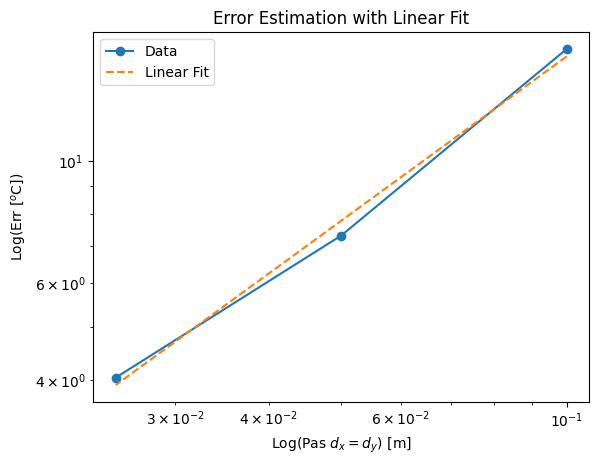

Linear Fit Coefficients:
Slope (Approximation Order): 0.9903
Intercept: 5.0184

Estimated error for dx = 0.007: 1.1105 degrees Celsius


In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Given data
d_Err_ar = np.array([00.1, 0.05, 0.025])  # Use the appropriate values from your data
Err_ar = np.array([15.94540631,  7.31470295,  4.0404055 ])  # Use the appropriate values from your data

# Perform linear fit
coefficients = np.polyfit(np.log(d_Err_ar), np.log(Err_ar), 1)

# Plot the linear fit
plt.loglog(d_Err_ar, Err_ar, '-o', label='Data')
plt.loglog(d_Err_ar, np.exp(np.polyval(coefficients, np.log(d_Err_ar))), '--', label='Linear Fit')
plt.title('Error Estimation with Linear Fit')
plt.xlabel('Log(Pas $d_x=d_y$) [m]')
plt.ylabel('Log(Err [$^o$C])')
plt.legend()
plt.show()

# Print the coefficients of the linear fit
print("Linear Fit Coefficients:")
print(f"Slope (Approximation Order): {coefficients[0]:.4f}")
print(f"Intercept: {coefficients[1]:.4f}")

# Estimate the error for dx = 0.007 using the linear fit
given_dx_value = 0.007
estimated_error = np.exp(np.polyval(coefficients, np.log(given_dx_value)))

# Print the result
print(f"\nEstimated error for dx = {given_dx_value}: {estimated_error:.4f} degrees Celsius")


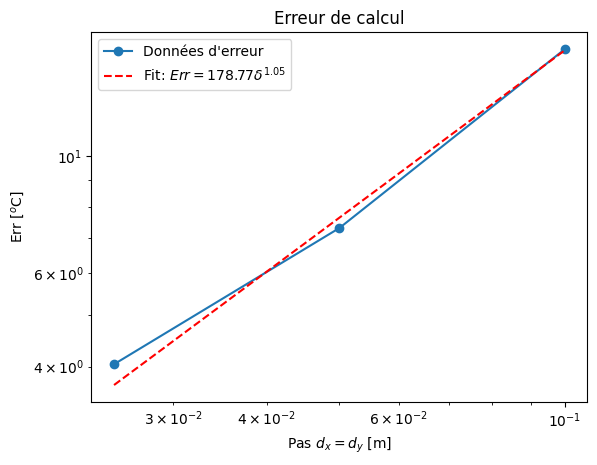

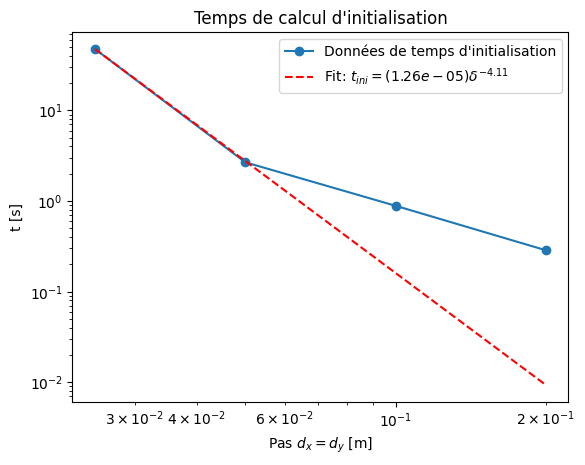

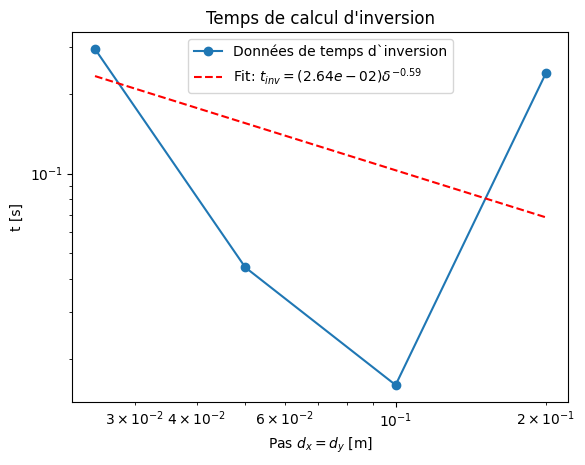

In [46]:
from scipy.optimize import curve_fit

# Define the model function
def power_law(x, A, p):
    return A * x**p

# Generate some example data
# x_data = np.array([1, 2, 3, 4, 5])
# y_data = np.array([2, 8, 18, 32, 50])

d_err_data = d_Err_ar[::-1]
d_time_data = d_ar[::-1]
Err_data = Err_ar[::-1]
tinv_data = tinv_ar[::-1]
tini_data = tini_ar[::-1]

# Use curve_fit to find the optimal parameters
params_err, covariance = curve_fit(power_law, d_err_data, Err_data)
params_tini, covariance2 = curve_fit(power_law, d_time_data, tini_data)
params_tinv, covariance3 = curve_fit(power_law, d_time_data, tinv_data)

# Extract the optimized parameters
A_err, p_err = params_err
A_tini, p_tini = params_tini
A_tinv, p_tinv = params_tinv

# Generate fitted curve using the optimized parameters
Err_fit = power_law(d_err_data, A_err, p_err)
tini_fit = power_law(d_time_data, A_tini, p_tini)
tinv_fit = power_law(d_time_data, A_tinv, p_tinv)

# Plot the original data and the fitted curve
plt.figure(8)
plt.loglog(d_err_data, Err_data, '-o', label="Données d'erreur")
plt.loglog(d_err_data, Err_fit, '--', label=f'Fit: $Err = {A_err:.2f}\delta^{{{p_err:.2f}}}$', color='red')
plt.title('Erreur de calcul')
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('Err [$^o$C]')
plt.legend()
plt.savefig('fit_erreur.png')

plt.figure(9)
plt.loglog(d_time_data, tinv_data,'-o', label="Données de temps d'initialisation")
plt.loglog(d_time_data, tinv_fit, '--', label=f'Fit: $t_{{ini}} = ({A_tinv:.2e})\delta^{{{p_tinv:.2f}}}$', color='red')
plt.title("Temps de calcul d'initialisation")
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend()
plt.savefig('fit_tini.png')


plt.figure(10)
plt.loglog(d_time_data, tini_data,'-o', label="Données de temps d`inversion")
plt.loglog(d_time_data, tini_fit, '--', label=f'Fit: $t_{{inv}} = ({A_tini:.2e})\delta^{{{p_tini:.2f}}}$', color='red')
plt.title("Temps de calcul d'inversion")
plt.xlabel('Pas $d_x=d_y$ [m]')
plt.ylabel('t [s]')
plt.legend()
plt.savefig('fit_tinv.png')



plt.show()
